In [19]:
import pymaltspro as pmp
import pymalts as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import wasserstein_trees as wstree

# Synthetic dataset -- MALTS

# Synthetic Dataset - MALTSPro

# Synthetic dataset used in Linbo's paper

In [52]:
def sample_from_qtl_fn(X_i, A_i, treatment_prob_i, error_i, qtl_list):
    y_i = []
    for qtl in qtl_list:
        y_i.append((-treatment_prob_i + A_i + X_i + error_i) * np.sin(np.pi * qtl)/8 + qtl)
    return y_i
def sample_from_qtl_fn_cf(X_i, A_i, treatment_prob_i, error_i, qtl_list):
    y_i = []
    for qtl in qtl_list:
        y_i.append((-treatment_prob_i + (1 - A_i) + X_i + error_i) * np.sin(np.pi * qtl)/8 + qtl)
    return y_i

np.random.seed(100)
n_units = 1000
n_obs_per_unit = 1001
feature_x = np.random.uniform(low = -1, high = 1, size = n_units)
treatment_probs = np.apply_along_axis(arr = feature_x, 
                                axis = 0, 
                                func1d = lambda x: np.exp(x)/(1 + np.exp(x)))
treatment = np.array([np.random.binomial(n = 1, p = i) for i in treatment_probs])
error = np.random.uniform(low = -0.5, high = 0.5, size = n_units)
y_qtls = np.random.uniform(low = 0, high = 1, size = (n_units, n_obs_per_unit))
y_obs = []
y_cf  = []
for i in range(n_units):
    y_obs.append(sample_from_qtl_fn(X_i = feature_x[i],
                       A_i = treatment[i],
                       treatment_prob_i = treatment_probs[i], 
                       error_i = error[i],
                       qtl_list = y_qtls[i, :]))
for i in range(n_units):
    y_cf.append(sample_from_qtl_fn_cf(X_i = feature_x[i],
                       A_i = treatment[i],
                       treatment_prob_i = treatment_probs[i], 
                       error_i = 0, # should be no noise in counterfactual
                       qtl_list = y_qtls[i, :]))
y_obs = np.array(y_obs)
y_cf  = np.array(y_cf)
y_mean = y_obs.mean(axis = 1)
y_cf_mean = y_cf.mean(axis = 1)

In [53]:
malts_data = pd.DataFrame({
    'X' : feature_x,
    'treatment' : treatment,
    'Y' : y_mean
})

In [54]:
# split into training and testing
np.random.seed(1001)
train_test_index = np.random.binomial(n = 1, p = 0.2, size = n_units).astype(bool)
train = malts_data.assign(keep = train_test_index).query('keep == 0').drop('keep', 1)
valid = malts_data.assign(keep = train_test_index).query('keep == 1').drop('keep', 1)
X_train = train.reset_index()
X_valid = valid.reset_index()
X_train = X_train.drop(['index', 'Y'], axis = 1)
X_valid = X_valid.drop(['index', 'Y'], axis = 1)
y_train = y_obs[~train_test_index, :]
y_valid =  y_obs[train_test_index, :]

In [55]:
malts = pm.malts(outcome = 'Y',
                 treatment = 'treatment',
                 data = train,
                 discrete = [],
                 C = 0.1,
                 k = 10,
                 reweight = False)

In [56]:
%%time
malts.fit(method = 'SLSQP')

CPU times: user 842 ms, sys: 118 ms, total: 959 ms
Wall time: 184 ms


     fun: 0.5325959499489149
     jac: array([2.23517418e-08])
 message: 'Optimization terminated successfully.'
    nfev: 13
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([8.94069521e-08])

In [57]:
malts_mg = malts.get_matched_groups(valid)
malts_cate = malts.CATE(MG = malts_mg)
malts_ate = malts_cate.CATE.mean()

In [58]:
malts_mg

X         Y      distance  treatment
10  query  0.782644  0.562108  0.000000e+00        1.0
    35     0.780823  0.585190  2.650076e-20        1.0
    788    0.778956  0.584376  1.087024e-19        1.0
    10     0.782644  0.562108  0.000000e+00        1.0
    197    0.804819  0.589626  3.930734e-18        1.0
...             ...       ...           ...        ...
991 577    0.764912  0.482517  1.356055e-16        0.0
    522    0.888377  0.540440  3.676496e-19        0.0
    469    0.630677  0.498935  5.591553e-16        0.0
    429    0.617369  0.472695  6.168423e-16        0.0
    447    0.608782  0.515732  6.555664e-16        0.0

[3864 rows x 4 columns]

In [59]:
true_ate = ((2 * treatment - 1) * y_mean + (2 * (1 - treatment) - 1) * y_cf_mean).mean()

In [60]:
# # check if it will work for pymaltspro
# maltspro = pmp.pymaltspro(X = X_train,
#                           y = y_train, 
#                           treatment = 'treatment', 
#                           discrete = [],
#                           C = 0.001,
#                           k = 10)
# %%time
# maltspro.fit(method = 'SLSQP')

In [61]:
def get_matched_groups(pmp_self, X_estimation, Y_estimation, k = 10):
    Xc = X_estimation[pmp_self.continuous].to_numpy()
    Xd = X_estimation[pmp_self.discrete].to_numpy()
    Y  = Y_estimation
    T  = X_estimation[pmp_self.treatment].to_numpy()
    # splitted estimation data into treatment assignments for matching
    df_T = X_estimation.loc[X_estimation[pmp_self.treatment] == 1]
    df_C = X_estimation.loc[X_estimation[pmp_self.treatment] == 0]
    Y_T  = Y_estimation[df_T.index.values, :]
    Y_C  = Y_estimation[df_C.index.values, :]
    D_T = np.zeros((Y.shape[0],Y_T.shape[0]))
    D_C = np.zeros((Y.shape[0],Y_C.shape[0]))
    # converting to numpy array
    Xc_T = df_T[pmp_self.continuous].to_numpy()
    Xc_C = df_C[pmp_self.continuous].to_numpy()
    Xd_T = df_T[pmp_self.discrete].to_numpy()
    Xd_C = df_C[pmp_self.discrete].to_numpy()

    # distance of treated units
    Dc_T = (np.ones((Xc_T.shape[0],Xc.shape[1],Xc.shape[0])) * Xc.T - (np.ones((Xc.shape[0],Xc.shape[1],Xc_T.shape[0])) * Xc_T.T).T)
    Dc_T = np.sum( (Dc_T * (pmp_self.Mc.reshape(-1,1)) )**2 , axis=1 )
    Dd_T = (np.ones((Xd_T.shape[0],Xd.shape[1],Xd.shape[0])) * Xd.T != (np.ones((Xd.shape[0],Xd.shape[1],Xd_T.shape[0])) * Xd_T.T).T )
    Dd_T = np.sum( (Dd_T * (pmp_self.Md.reshape(-1,1)) )**2 , axis=1 )
    D_T = (Dc_T + Dd_T).T

    # distance of control units
    Dc_C = (
        np.ones(
            (
                Xc_C.shape[0],
                Xc.shape[1],
                Xc.shape[0]
            )	
        ) * Xc.T - 
            (
        np.ones(
            (
                Xc.shape[0],
                Xc.shape[1],
                Xc_C.shape[0])
            ) * Xc_C.T).T
        )
    Dc_C = np.sum( (Dc_C * (pmp_self.Mc.reshape(-1,1)) )**2 , axis=1 )
    Dd_C = (
        np.ones(
            (
                Xd_C.shape[0],
                Xd.shape[1],
                Xd.shape[0])
            ) * Xd.T != (
        np.ones(
            (
                Xd.shape[0],
                Xd.shape[1],
                Xd_C.shape[0]
                )
            ) * Xd_C.T).T )
    Dd_C = np.sum( (Dd_C * (pmp_self.Md.reshape(-1,1)) )**2 , axis=1 )
    D_C = (Dc_C + Dd_C).T

    MG = {}
    index = X_estimation.index
    for i in range(Y.shape[0]):
        #finding k closest control units to unit i
        idx = np.argpartition(D_C[i,:],k)
        matched_df_C = pd.DataFrame( 
            np.hstack( 
                (
                    Xc_C[idx[:k],:], 
                    Xd_C[idx[:k],:].reshape((k,len(pmp_self.discrete))), 
                    # Y_C[idx[:k]].reshape(-1,1), 
                    D_C[i,idx[:k]].reshape(-1,1), 
                    np.zeros((k,1)) ) 
                ), 
            index = df_C.index[idx[:k]],
            columns=pmp_self.continuous+pmp_self.discrete+['distance',pmp_self.treatment] 
            )

        #finding k closest treated units to unit i
        idx = np.argpartition(D_T[i,:],k)
        matched_df_T = pd.DataFrame( 
            np.hstack( 
                (
                    Xc_T[idx[:k],:], 
                    Xd_T[idx[:k],:].reshape((k,len(pmp_self.discrete))), 
                    # Y_T[idx[:k]].reshape(-1,1), 
                    D_T[i,idx[:k]].reshape(-1,1), 
                    np.ones((k,1)) ) 
                ), 
            index=df_T.index[idx[:k]], 
            columns=pmp_self.continuous+pmp_self.discrete+['distance',pmp_self.treatment] 
            )
        matched_df = pd.DataFrame(
            np.hstack(
                (
                    Xc[i], 
                    Xd[i], 
                    # Y[i], 
                    0, 
                    T[i])
                ).reshape(1,-1), 
#             index=['query'], 
            index = [i],
            columns=pmp_self.continuous+pmp_self.discrete+['distance',pmp_self.treatment]
            )
        matched_df = matched_df.append(matched_df_T.append(matched_df_C))
        matched_df['unit_treatment'] = X_estimation.loc[i, pmp_self.treatment]
        MG[index[i]] = matched_df
#     return MG
    MG_X_df = pd.concat(MG).reset_index().rename(columns = {'level_0' : 'unit' ,  'level_1' : 'matched_unit'})
    
    return MG_X_df


def barycenter_imputation(pmp_self, X_estimation, Y_estimation, MG):
    Y_counterfactual = []
    for i in X_estimation.index.values:
        # make a holder list for adding matched units' outcomes
        matched_unit_ids = MG.query(f'unit == {i}').query('treatment != unit_treatment').matched_unit.values
        matched_unit_outcomes = Y_estimation[matched_unit_ids, :]
        y_i_counterfactual = pmp.wasserstein2_barycenter(
            sample_array_1_through_n = matched_unit_outcomes, 
            weights = np.repeat(1/matched_unit_outcomes.shape[0], matched_unit_outcomes.shape[0]),
            n_samples_min=pmp_self.n_samples_min
        )
        Y_counterfactual.append(y_i_counterfactual)
    return np.array(Y_counterfactual)


def sample_quantile(quantile_fn, quantile):
    '''
    description
    -----------
    linearly interpolate quantile function and return value of a given quantile
    
    parameters
    ----------
    quantile_fn : numpy array with values of quantile function at specified quantiles
    quantile : value of quantile
    n_qtls : size of quantile function
    
    returns
    -------
    quantile function evaluated at specified quantile
    '''
    n_qtls = quantile_fn.shape[0] - 1
    quantile_index = quantile * n_qtls
    quantile_floor = int(np.floor(quantile_index))
    quantile_ceil  = int(np.ceil(quantile_index))
#     return quantile_floor, quantile_ceil, quantile_index
    if quantile_floor == quantile_ceil == quantile_index:
        return(quantile_fn[quantile_floor])
    else:
        return np.sum([quantile_fn[quantile_floor] * (quantile_index - quantile_floor),
            quantile_fn[quantile_ceil] * (quantile_ceil - quantile_index)])


def ITE(y_estimation, y_cf, n_mc_samples, observed_treatment):
    if observed_treatment == 1:
        y_treated = np.random.choice(a = y_estimation, size = n_mc_samples, replace = True)
        y_control = np.random.choice(a = y_cf, size = n_mc_samples, replace = True)
    else:
        y_treated = np.random.choice(a = y_cf, size = n_mc_samples, replace = True)
        y_control = np.random.choice(a = y_estimation, size = n_mc_samples, replace = True)
    return (y_treated > y_control).mean()

def linbo_ITE(y_obs, y_cf, observed_treatment, reference_distribution, y_obs_qtl_id = False):
    '''
    description
    -----------
    Compute Y_i^-1(1) \circ \lambda(t) - Y_i^{-1}(0) \circ \lambda(t)
    
    parameters
    ----------
    y_obs : array of samples/quantiles for the true observed outcome in estimation set
    y_cf : array of quantile function for counterfactual outcome
    observed_treatment : boolean that is True iff treated outcome observed, False otherwise
    reference_distribution : a 2D array mapping samples from reference distribution to density of sample
        -- reference distribution _must_ be continuous
        -- col 1 is sample
        -- col 2 is prob of observing sample
    y_obs_qtl_id : boolean that is True iff y_estimation is a quantile function
    '''
    quantiles = np.linspace(start = 0, stop = 1, num = y_cf.shape[0])
    if y_obs_qtl_id:
        y_estimation = y_obs
    else:
        y_estimation = np.quantile(y_obs, quantiles)
    
    ylambda_treated = []
    ylambda_control = []
    if observed_treatment == 1:
        for i in reference_distribution[1, :]:
            ylambda_treated.append(sample_quantile(quantile_fn = y_estimation, quantile = i))
            ylambda_control.append(sample_quantile(quantile_fn = y_cf, quantile = i))
    else:
        for i in reference_distribution[1, :]:
            ylambda_treated.append(sample_quantile(quantile_fn = y_cf, quantile = i))
            ylambda_control.append(sample_quantile(quantile_fn = y_estimation, quantile = i))

    ylambda_treated = np.array(ylambda_treated)
    ylambda_control = np.array(ylambda_control)
    ylambda_treated_minus_control = ylambda_treated - ylambda_control
    return_array = np.array([reference_distribution[0, :], ylambda_treated_minus_control])
    return return_array

def mise(y_pred, y_true):
    return ((y_pred - y_true)**2).sum(axis = 1).mean()
    

In [62]:
with open('maltspro_linbo.pkl', 'rb') as f:
    maltspro = pickle.load(f)

In [63]:
# maltspro.get_matched_groups(X_estimation=X_valid, Y_estimation=list(y_valid), k = 10)
mg_df = get_matched_groups(pmp_self = maltspro, X_estimation=X_valid, Y_estimation= y_valid, k =10)

In [64]:
y_bary = barycenter_imputation(pmp_self = maltspro, X_estimation=X_valid, Y_estimation= y_valid, MG = mg_df)

In [93]:
ite_estimates = []
ite_true = []
for i in range(y_valid.shape[0]):
    ite_estimates.append(ITE(y_estimation = y_valid[i, :], 
        y_cf = y_bary[i, :], 
        n_mc_samples = 100000, 
        observed_treatment = X_valid.loc[0, 'treatment']))
    ite_true.append(ITE(y_estimation = y_valid[i, :], 
        y_cf = y_cf[i, :], 
        n_mc_samples = 100000, 
        observed_treatment = X_valid.loc[0, 'treatment']))
ite_estimates = np.array(ite_estimates)
ite_true = np.array(ite_true)

In [94]:
np.abs(ite_estimates - ite_true).mean()

0.04968146739130436

In [95]:
untreated_bary = []
for i in range(y_valid.shape[0]):
    if X_valid.loc[i, 'treatment'] == 1:
        untreated_bary.append(y_valid[i, :])
    else:
        untreated_bary.append(y_bary[i, :])
untreated_bary = pmp.wasserstein2_barycenter(sample_array_1_through_n = np.array(untreated_bary), 
                                         weights = np.repeat(1/len(untreated_bary), len(untreated_bary)), 
                                         n_samples_min = maltspro.n_samples_min)
untreated_bary_cdf = np.array([untreated_bary, np.linspace(0, 1, untreated_bary.shape[0])])

In [96]:
linbo_ate_array = []
for i in range(y_valid.shape[0]):
    linbo_ite_array = linbo_ITE(y_obs = y_valid[i, :], 
              y_cf = y_bary[i, :], 
              reference_distribution = untreated_bary_cdf, 
              observed_treatment =X_valid.loc[i, 'treatment'], 
              y_obs_qtl_id = False
             )
    linbo_ate_array.append(linbo_ite_array[1, :])
linbo_ate_array = np.array(linbo_ate_array).mean(axis = 0)

In [97]:
linbo_ate_true = np.array([np.sin(np.pi * t)/8 for t in untreated_bary_cdf[0, :]])

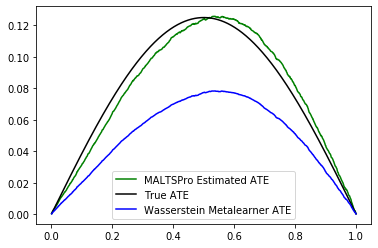

In [106]:
plt.plot(linbo_ite_array[0, :], linbo_ate_array, label = 'MALTSPro Estimated ATE', c = 'green')
plt.plot(linbo_ite_array[0, :], linbo_ate_true, label = 'True ATE', c = 'black')
# plt.legend()
# plt.show()
plt.plot(linbo_ite_array[0, :], linbo_ate_wrf_array, label = 'Wasserstein Metalearner ATE', c = 'blue')
# plt.plot(linbo_ite_array[0, :], linbo_ate_true, label = 'True ATE', c = 'black')
plt.legend()
plt.show()

In [99]:
np.sqrt(((linbo_ate_true - linbo_ate_array)**2).sum()) * 100

20.614864293393083

In [101]:
wrf = wstree.wass_forest(X = X_train, 
                   y = y_train,
                   y_quantile_id=False,
                   min_samples_split=None,
                   max_depth=None,
                   depth=None,
                   node_type=None,
                   n_trees=20,
                   seed=999,
                   n_samples_min=None)

In [41]:
y_wrf_bary = wrf.predict(X_valid = X_valid.assign(treatment = 1 - X_valid.treatment))

In [47]:
ite_wrf_estimates = []
for i in range(y_valid.shape[0]):
    ite_wrf_estimates.append(
        ITE(y_estimation = y_valid[i, :], 
        y_cf = y_wrf_bary[i, :],
        n_mc_samples = 100000,
        observed_treatment = X_valid.treatment[i]))
ite_wrf_estimates = np.array(ite_wrf_estimates)

In [77]:
np.abs(ite_wrf_estimates - ite_true).mean()

0.07750423913043479

In [91]:
linbo_ate_wrf_array = []
for i in range(y_valid.shape[0]):
    linbo_ite_wrf_array = linbo_ITE(y_obs = y_valid[i, :], 
              y_cf = y_wrf_bary[i, :], 
              reference_distribution = untreated_bary_cdf, 
              observed_treatment =X_valid.loc[i, 'treatment'], 
              y_obs_qtl_id = False
             )
    linbo_ate_wrf_array.append(linbo_ite_wrf_array[1, :])
linbo_ate_wrf_array = np.array(linbo_ate_wrf_array).mean(axis = 0)

In [92]:
np.sqrt(((linbo_ate_true - linbo_ate_wrf_array)**2).sum()) * 100

105.62425908388089

In [35]:
# %%time
# pmp_object = pmp.pymaltspro(X = X_df,
#                             y = Y, 
#                             treatment = 'treatment', 
#                             discrete = ['x1', 'x2'],
#                             C = 0.001,
#                             k = 10, )

In [20]:
# %%time
# pmp_object.fit(M_init = np.array(((1, 1), )))

CPU times: user 16min 56s, sys: 2.18 s, total: 16min 58s
Wall time: 16min 59s


     fun: nan
   maxcv: 0.0
 message: 'NaN result encountered.'
    nfev: 3
  status: 5
 success: False
       x: array([[2., 2.]])